In [1]:
from __future__ import annotations

from typing import List

In [2]:
import numpy as np
import sklearn

from matplotlib import pyplot as plt

from sklearn.covariance import EmpiricalCovariance
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

In [3]:
import sys
sys.path.insert(0, "..")

import phepy

from phepy.detector import OutOfDistributionDetector, PercentileScorer
from phepy.plot import plot_all_toy_examples
from phepy.toys import ToyExample
from phepy.toys.line import LineToyExample
from phepy.toys.circle import CircleToyExample
from phepy.toys.haystack import HaystackToyExample

In [4]:
line = LineToyExample(np.random.default_rng(42))
circle = CircleToyExample(np.random.default_rng(42))
haystack = HaystackToyExample(np.random.default_rng(42))

In [5]:
class OneOptimalDetector(OutOfDistributionDetector):
    def __init__(self, toys: List[ToyExample]) -> OneOptimalDetector:
        self.__toys = toys
    
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False
    
    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> OneOptimalDetector:
        
        for toy in self.__toys:
            if X_train.shape != toy.X_train.shape:
                continue
            
            if np.all(X_train == toy.X_train):
                self.__toy = toy
                return self
        
        raise KeyError("unknown toy example")

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return np.sum((self.__toy.reconstruct(X_test) - X_test)**2, axis=1)

In [6]:
class MahalanobisDistanceDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> MahalanobisDistanceDetector:
        self.__X_cov = EmpiricalCovariance().fit(X_train)
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.__X_cov.mahalanobis(X_test)

In [7]:
class TruncatedPCADetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return False

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> TruncatedPCADetector:
        if X_train.shape[1] > 2:
            n_components = 0.95
        else:
            n_components = 1
        
        self.__X_pca = PCA(n_components=n_components, random_state=42).fit(X_train)
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return np.sum((self.__X_pca.inverse_transform(self.__X_pca.transform(X_test)) - X_test)**2, axis=1)

In [8]:
class LocalOutlierFactorDetector(OutOfDistributionDetector):
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return True

    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> LocalOutlierFactorDetector:
        self.__X_lof = LocalOutlierFactor(novelty=True).fit(X_train)
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.__X_lof.score_samples(X_test)

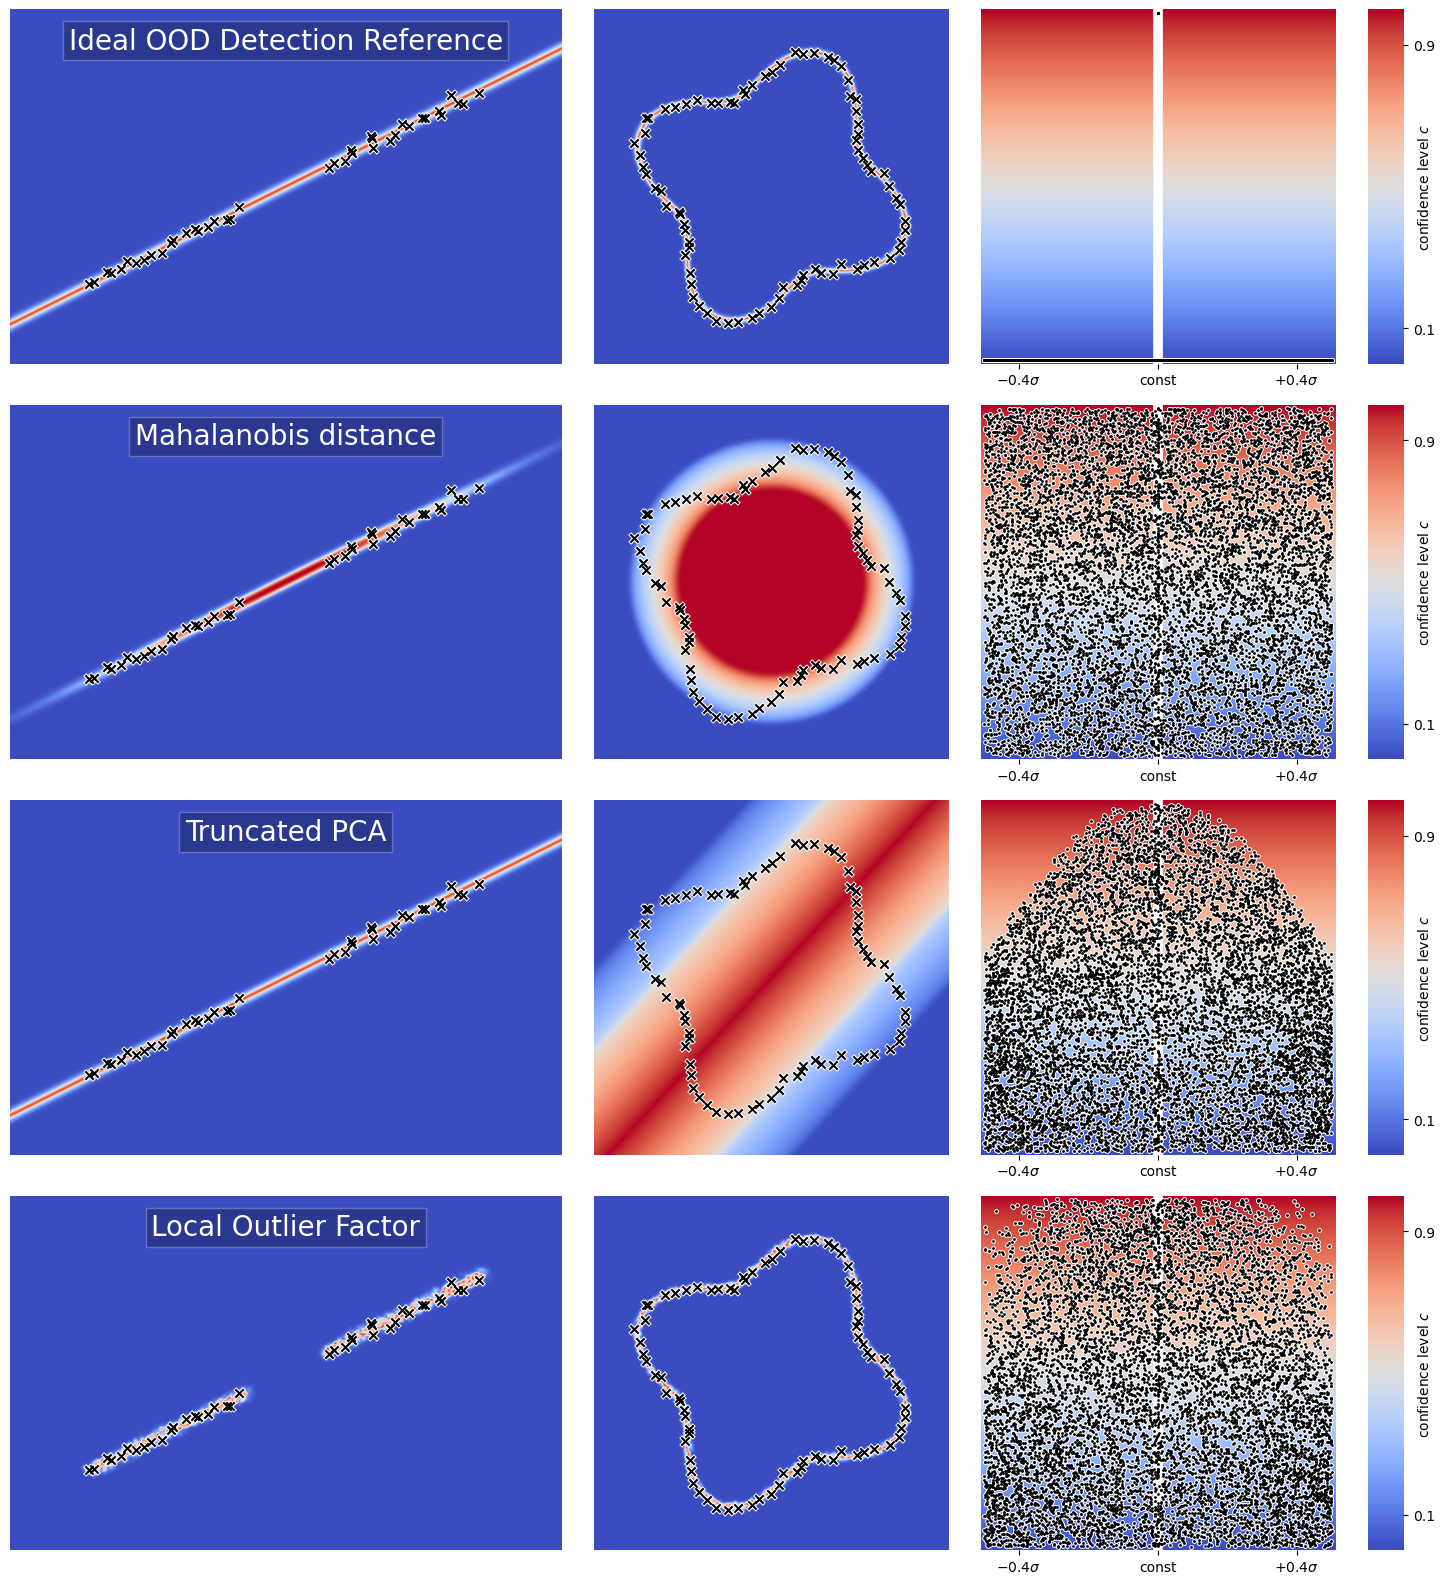

In [9]:
fig = plot_all_toy_examples(
    scorers = {
        "Ideal OOD Detection Reference": PercentileScorer(OneOptimalDetector([line, circle, haystack])),
        "Mahalanobis distance": PercentileScorer(MahalanobisDistanceDetector()),
        "Truncated PCA": PercentileScorer(TruncatedPCADetector()),
        "Local Outlier Factor": PercentileScorer(LocalOutlierFactorDetector()),
    },
    toys = [line, circle, haystack],
    cmap = "coolwarm", # use e.g. "viridis" to be colour-blind safe
)

plt.show()